In [ ]:
import nannyml as nml
import matplotlib.pyplot as plt
from IPython.display import display

reference_df, analysis_df, analysis_target_df = nml.load_synthetic_car_loan_dataset()

analysis_df = analysis_df.merge(analysis_target_df, left_index=True, right_index=True)

column_names = [
    'car_value', 'salary_range', 'debt_to_income_ratio', 'loan_length', 'repaid_loan_on_prev_car', 'size_of_downpayment', 'driver_tenure',
]
univ_calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    timestamp_column_name='timestamp',
    continuous_methods=['jensen_shannon'],
    categorical_methods=['jensen_shannon'],
    chunk_size=5000
)

univ_calc.fit(reference_df)
univariate_results = univ_calc.calculate(analysis_df)

realized_calc = nml.PerformanceCalculator(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='repaid',
    timestamp_column_name='timestamp',
    problem_type='classification_binary',
    metrics=['roc_auc'],
    chunk_size=5000)
realized_calc.fit(reference_df)
realized_perf_results = realized_calc.calculate(analysis_df)

ranker = nml.CorrelationRanker()
# ranker fits on one metric and reference period data only
ranker.fit(
    realized_perf_results.filter(period='reference'))
# ranker ranks on one drift method and one performance metric
correlation_ranked_features = ranker.rank(
    univariate_results,
    realized_perf_results,
    only_drifting = False)
display(correlation_ranked_features)

161 {'car_value': [<nannyml.drift.univariate.methods.JensenShannonDistance object at 0x7f60f853b970>], 'salary_range': [], 'debt_to_income_ratio': [<nannyml.drift.univariate.methods.JensenShannonDistance object at 0x7f60f853bb20>], 'loan_length': [<nannyml.drift.univariate.methods.JensenShannonDistance object at 0x7f60f853bb50>], 'repaid_loan_on_prev_car': [], 'size_of_downpayment': [], 'driver_tenure': [<nannyml.drift.univariate.methods.JensenShannonDistance object at 0x7f60f853ba30>]}


,column_name,pearsonr_correlation,pearsonr_pvalue,has_drifted,rank
0,repaid_loan_on_prev_car,0.929710,3.076474e-09,True,1
1,loan_length,0.926671,4.452334e-09,True,2
2,salary_range,0.921556,8.014868e-09,True,3
3,car_value,0.920795,8.717926e-09,True,4
4,debt_to_income_ratio,0.317390,1.726986e-01,False,5
5,size_of_downpayment,0.154622,5.151128e-01,False,6
6,driver_tenure,-0.177018,4.553046e-01,False,7


In [ ]:
print(correlation_ranked_features.to_markdown(tablefmt="grid"))

+----+-------------------------+------------------------+-------------------+---------------+--------+
|    | column_name             |   pearsonr_correlation |   pearsonr_pvalue | has_drifted   |   rank |
+====+=========================+========================+===================+===============+========+
|  0 | repaid_loan_on_prev_car |               0.92971  |       3.07647e-09 | True          |      1 |
+----+-------------------------+------------------------+-------------------+---------------+--------+
|  1 | loan_length             |               0.926671 |       4.45233e-09 | True          |      2 |
+----+-------------------------+------------------------+-------------------+---------------+--------+
|  2 | salary_range            |               0.921556 |       8.01487e-09 | True          |      3 |
+----+-------------------------+------------------------+-------------------+---------------+--------+
|  3 | car_value               |               0.920795 |       8.71793e-

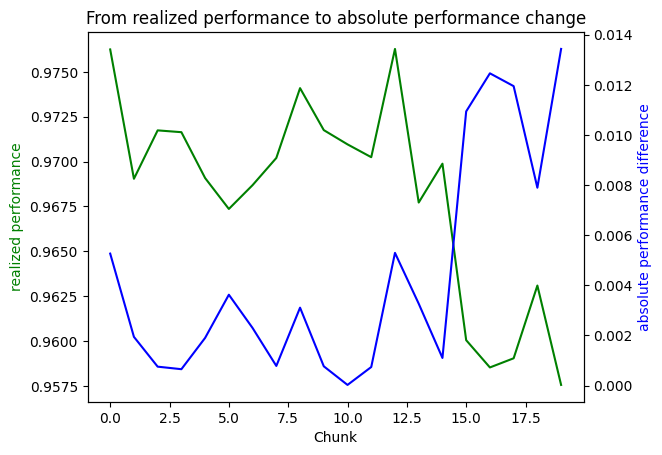

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(realized_perf_results.filter(period='all', metrics=['roc_auc']).to_df()[('roc_auc', 'value')].to_numpy(), 'g-')
ax2.plot(ranker.absolute_performance_change, 'b-')
ax1.set_xlabel('Chunk')
ax1.set_ylabel('realized performance', color='g')
ax2.set_ylabel('absolute performance difference', color='b')
plt.title("From realized performance to absolute performance change")
plt.savefig("../_static/how-it-works/ranking-abs-perf.svg", bbox_inches='tight')

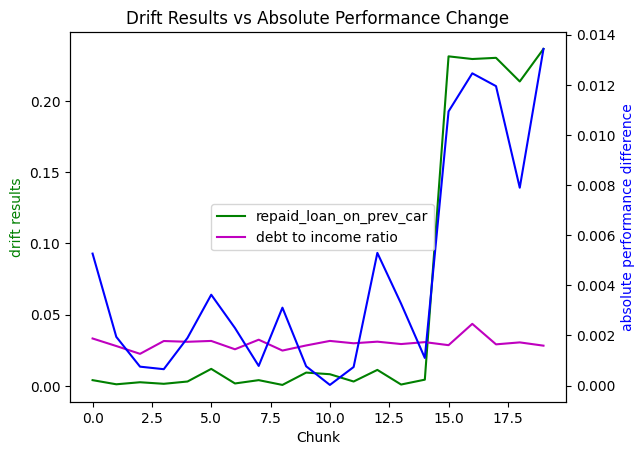

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(ranker.absolute_performance_change, 'b-')
ax1.plot(
    univariate_results.filter(
        period='all', column_names=['repaid_loan_on_prev_car']
    ).to_df().loc[
        :, ('repaid_loan_on_prev_car', slice(None), 'value')
    ].to_numpy().ravel(),
    'g-', label='repaid_loan_on_prev_car'
)
ax1.plot(
    univariate_results.filter(
        period='all', column_names=['debt_to_income_ratio']
    ).to_df().loc[
        :, ('debt_to_income_ratio', slice(None), 'value')
    ].to_numpy().ravel(),
    'm-', label='debt to income ratio'
)
ax1.set_xlabel('Chunk')
ax1.set_ylabel('drift results', color='g')
ax2.set_ylabel('absolute performance difference', color='b')
fig.legend(loc="center")
plt.title("Drift Results vs Absolute Performance Change")
plt.savefig("../_static/how-it-works/ranking-abs-perf-features-compare.svg", bbox_inches='tight')
